In [46]:
import Control.Monad.Bayes.Class
import Control.Monad.Bayes.Sampler.Strict
import Control.Monad.Bayes.Weighted
import Control.Monad.Bayes.Enumerator
import Control.Monad
import Control.Arrow
import Data.Bifunctor (bimap)
import Numeric.Log
import qualified Data.Text as T

:e TupleSections


:l ../plotting.hs

# Bayesian Models

Monad-Bayes exports a `Bayesian` datatype to make using Bayesian models easier. The idea is that you specify your model as a prior, generative model and a likelihood (separate from the generative model because you can't always get the density of a sample from a distribution).

Once you've done that, a number of standard operations, like obtaining the posterior or the posterior predictive, are automated for you.

Here's a simple example:

In [143]:
model :: MonadSample m => Bayesian m Bool Double
model = Bayesian {
    prior = bernoulli 0.5,
    generative = \x -> normal (if x then 2 else (-2)) 1,
    likelihood  = \x y -> normalPdf (if x then 2 else (-2)) 1 y
    }

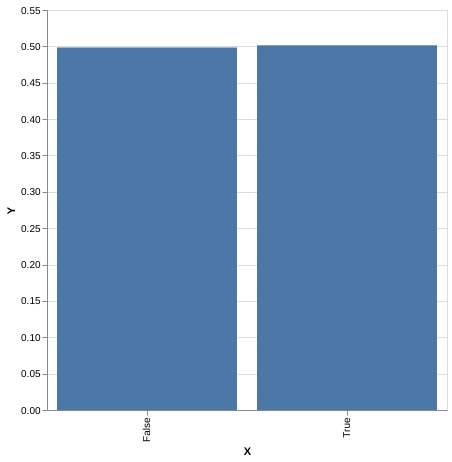

In [50]:
sampler $ 
    plot . fmap (first (T.pack . show)) . toEmpirical <$> 
    replicateM 100000 (prior model)

Prior predictive model is an application of prior distribution to a generative distribution.

Similarly as in `Sampling.ipynb` example we need to introduce a constant weight by mapping samples to a pair (value, score) with `(,constWeight) <$> `.

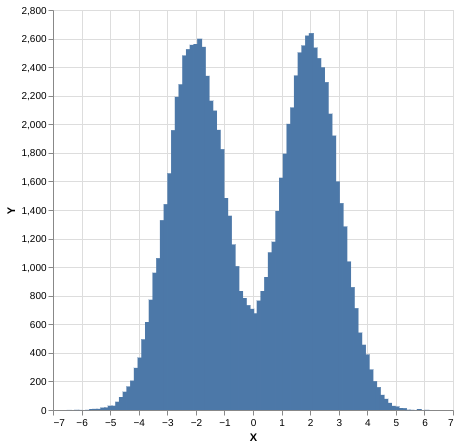

In [64]:
constWeight = 1 :: Log Double

sampler $ plot . histogramToList . histogram 100 <$> replicateM 100000 ((,constWeight) <$>  priorPredictive model)

priorPredictivePosterior model is 

In [67]:
:i normalPdf

normalPdf :: Double -> Double -> Double -> Log Double 	-- Defined in ‘Control.Monad.Bayes.Class’

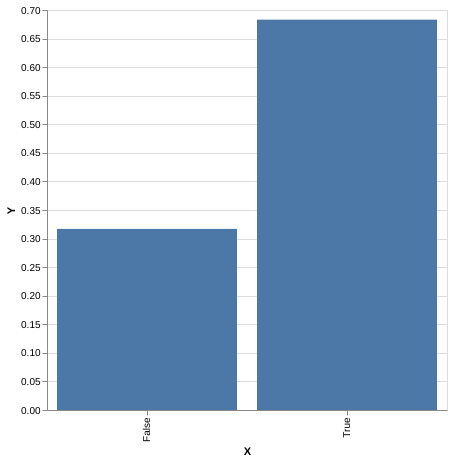

In [124]:
sampler $ 
    plot . fmap (bimap (T.pack . show) (ln . exp)) . toEmpiricalWeighted <$> 
    replicateM 1000 (weighted $ posterior model [3,3,3,3,-3,-2.8,-3,-3])

In [134]:
 sampler $ replicateM 3 (weighted $ posterior model [0,2,0,0])

[(True,6.278752612396416e-5),(False,2.106286851304267e-8),(True,6.278752612396416e-5)]

In [146]:
(likelihood model) True 0.1

Line 1: Redundant bracket
Found:
(likelihood model) True
Why not:
likelihood model True

: 

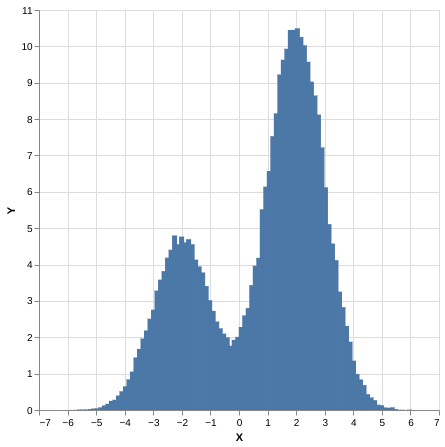

In [130]:
sampler $ plot . histogramToList . histogram 100 <$> replicateM 100000 (weighted $ posteriorPredictive model [0.1,0.1])

# Regression

And now an example with a regression:

In [14]:
:e BlockArguments 

range :: [Double]
range = [-10,-9.9..10] 


regression :: MonadSample m => Bayesian m (Double, Double, Double) [Double]
regression = Bayesian {
    prior = do 
            slope <- normal 0 2
            intercept <- normal 0 2
            noise <- gamma 4 4
            return (slope, intercept, noise),
    
    generative = \(slope, intercept, noise) -> do
            forM range \x -> normal (x*slope + intercept) (sqrt noise),
            
    likelihood = \(slope, intercept, noise) ys -> Prelude.sum [normalPdf (x*slope + intercept) (sqrt noise) y | (x,y) <- zip range ys] 
                
    }


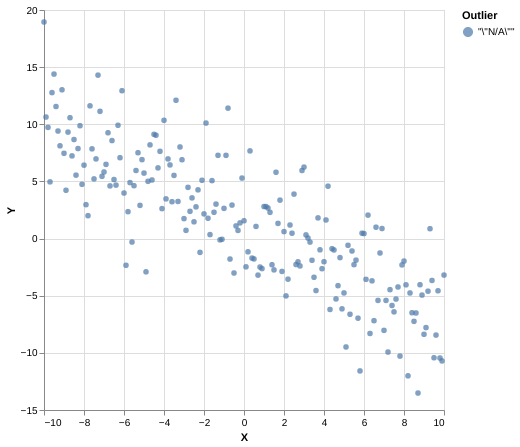

In [15]:
ys <- sampler $ priorPredictive regression

plot (fmap (second (T.pack . show)) (zip (zip range ys) (Prelude.repeat "N/A")))

In [16]:
import Control.Monad.Bayes.Inference.MCMC

ys <- sampleIOfixed $ mcmc MCMCConfig {numMCMCSteps = 5000, numBurnIn = 300, proposal = SingleSiteMH} 
    $ posteriorPredictive regression [take 200 $ repeat 1]


Line 1: Use head
Found:
ys !! 0
Why not:
head ys

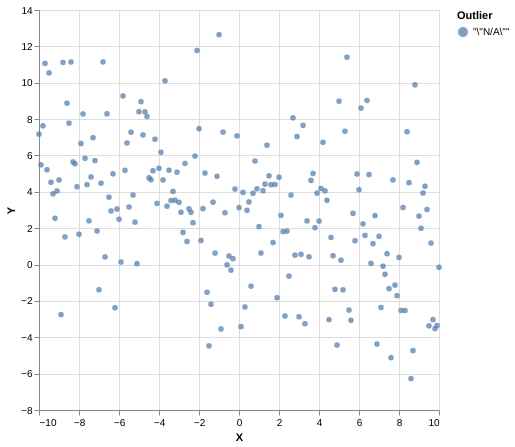

In [17]:
plot (fmap (second (T.pack . show)) (zip (zip range $ ys !! 0) (Prelude.repeat "N/A")))